In [1]:
import numpy as np
import pandas as pd

from molloader import *
from ML_utils import *

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split, KFold

In [2]:
def drop_duplicates(df):
    df = df.drop_duplicates(subset="compound", keep="first")
    print("Number of molecules", df.shape[0])
    return df

In [3]:
def get_all_elements(df):
      return np.unique(np.hstack(np.array(df.species)))

In [4]:
class VoxelNet(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        # (N, C, D, H, W)
        self.conv1 = nn.Sequential(
            nn.Conv3d(in_channels, 16, 3, padding=0, stride=1),
            #nn.BatchNorm3d(16),
            nn.LeakyReLU(0.3),
            nn.MaxPool3d(2))
        
        self.conv2 = nn.Sequential(
            nn.Conv3d(16, 16, 3, padding=0, stride=1),
            nn.LeakyReLU(0.3),
            nn.MaxPool3d(2))
        
        self.conv3 = nn.Sequential(
            nn.Conv3d(16, 16, 3, padding=0, stride=1),
            nn.LeakyReLU(0.3))
        
        self.regressor = nn.Sequential(nn.Flatten(),
                                        nn.Linear(1024, 32),
                                        nn.LeakyReLU(0.3),
                                        nn.Linear(32, 8),
                                        nn.LeakyReLU(0.3),
                                        nn.Linear(8, 1))
    def forward(self, x):
        #print(x.shape)
        x = self.conv1(x)
        # print("conv1", x.shape)
        x = self.conv2(x)
        # print("conv2", x.shape)
        x = self.conv3(x)
        # print("conv3", x.shape)
        x = self.regressor(x)
        return x

In [5]:
df = pd.read_pickle("data/icsd_221_cp5_3_species.pkl")
df = drop_duplicates(df)
df

Number of molecules 377


,auid,aurl,compound,composition,species,natoms,spacegroup,pearson_symbol,geometry,positions_fractional,positions_cartesian,enthalpy_atom,enthalpy_formation_atom
0,aflow:c2bae074d76f81b6,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/CUB/Ag1F3...,Ag1F3Zn1,"[1, 3, 1]","[Ag, F, Zn]",5,221,cP5,"[3.979183, 3.979183, 3.979183, 90.0, 90.0, 90.0]","[[0.0, 0.0, 0.0], [0.5, 0.5, 0.0], [0.0, 0.5, ...","[[0.0, 0.0, 0.0], [1.98959, 1.98959, -0.0], [0...",-3.35725,None
1,aflow:c568d79d0d0e9fc8,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/CUB/Ag1Mn...,Ag1Mn3N1,"[1, 3, 1]","[Ag, Mn, N]",5,221,cP5,"[4.265445, 4.265445, 4.265445, 90.0, 90.0, 90.0]","[[0.0, 0.0, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 2.13272, 2.13272], [2....",-5.99960,None
2,aflow:8944b3eb2c189cb7,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/CUB/Ag1Nb...,Ag1Nb1O3,"[1, 1, 3]","[Ag, Nb, O]",5,221,cP5,"[4.000268, 4.000268, 4.000268, 90.0, 90.0, 90.0]","[[0.5, 0.5, 0.5], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[[2.00013, 2.00013, 2.00013], [0.0, 0.0, 0.0],...",-6.76521,None
3,aflow:9da57f587b92d20f,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/CUB/Ag3I1...,Ag3I1S1,"[3, 1, 1]","[Ag, I, S]",5,221,cP5,"[5.0311, 5.0311, 5.0311, 90.0, 90.0, 90.0]","[[0.5, 0.5, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, ...","[[2.51555, 2.51555, 0.0], [-0.0, 2.51555, 2.51...",-1.61106,None
4,aflow:d43abd3deaeccc51,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/CUB/Al1Bi...,Al1Bi1O3,"[1, 1, 3]","[Al, Bi, O]",5,221,cP5,"[3.793297, 3.793297, 3.793297, 90.0, 90.0, 90.0]","[[0.5, 0.5, 0.5], [0.0, 0.0, 0.0], [0.0, 0.5, ...","[[1.89665, 1.89665, 1.89665], [0.0, 0.0, 0.0],...",-6.54116,-2.28122
...,...,...,...,...,...,...,...,...,...,...,...,...,...
722,aflow:f2a5b2edf497bb0b,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/CUB/O3Sn1...,O3Sn1Ti1,"[3, 1, 1]","[O, Sn, Ti]",5,221,cP5,"[3.980776, 3.980776, 3.980776, 90.0, 90.0, 90.0]","[[0.5, 0.5, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, ...","[[1.99039, 1.99039, -0.0], [0.0, 1.99039, 1.99...",-6.92630,None
723,aflow:493eb6e26780d785,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/CUB/O3Sr1...,O3Sr1Tc1,"[3, 1, 1]","[O, Sr, Tc]",5,221,cP5,"[4.045254, 4.045254, 4.045254, 90.0, 90.0, 90.0]","[[0.5, 0.0, 0.0], [0.0, 0.5, 0.0], [0.0, 0.0, ...","[[2.02263, 0.0, 0.0], [0.0, 2.02263, 0.0], [-0...",-6.91254,None
725,aflow:37c7f43d3abe11ce,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/CUB/O3Sr1...,O3Sr1Ti1,"[3, 1, 1]","[O, Sr, Ti]",5,221,cP5,"[3.97291, 3.97291, 3.97291, 90.0, 90.0, 90.0]","[[0.0, 0.5, 0.5], [0.5, 0.0, 0.5], [0.5, 0.5, ...","[[0.0, 1.98645, 1.98645], [1.98645, 0.0, 1.986...",-7.47382,None
751,aflow:6381b955a3963bf3,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/CUB/O3Sr1...,O3Sr1V1,"[3, 1, 1]","[O, Sr, V]",5,221,cP5,"[3.897829, 3.897829, 3.897829, 90.0, 90.0, 90.0]","[[0.5, 0.0, 0.0], [0.0, 0.5, 0.0], [0.0, 0.0, ...","[[1.94891, 0.0, -0.0], [-0.0, 1.94891, 0.0], [...",-7.35920,None


In [6]:
seed_everything()
train_df, test_df = train_test_split(df, test_size=0.1)
print(train_df.shape, test_df.shape)

(339, 13) (38, 13)


In [7]:
elements = get_all_elements(df)
nchannel = len(elements)
nchannel, elements

(76,
 array(['Ag', 'Al', 'As', 'Au', 'B', 'Ba', 'Be', 'Bi', 'Br', 'C', 'Ca',
        'Cd', 'Ce', 'Cl', 'Co', 'Cr', 'Cs', 'Cu', 'Dy', 'Er', 'Eu', 'F',
        'Fe', 'Ga', 'Gd', 'Ge', 'H', 'Hf', 'Hg', 'Ho', 'I', 'In', 'Ir',
        'K', 'La', 'Li', 'Lu', 'Mg', 'Mn', 'Mo', 'N', 'Na', 'Nb', 'Nd',
        'Ni', 'O', 'P', 'Pa', 'Pb', 'Pd', 'Pr', 'Pt', 'Pu', 'Rb', 'Rh',
        'Ru', 'S', 'Sb', 'Sc', 'Si', 'Sn', 'Sr', 'Ta', 'Tb', 'Tc', 'Th',
        'Ti', 'Tl', 'Tm', 'U', 'V', 'W', 'Y', 'Yb', 'Zn', 'Zr'],
       dtype='<U2'))

In [8]:
net = VoxelNet(nchannel)
count_parameters(net)

79777

Initialised MolLoader with 339 molecules. sigma = 0.1, L=12.8, N=32, nchannel=76, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 38 molecules. sigma = 0.1, L=12.8, N=32, nchannel=76, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 27.649011611938477 val loss 27.423416137695312
Epoch 1: train loss 22.86301612854004 val loss 14.535316467285156
Epoch 2: train loss 7.457096099853516 val loss 6.862462997436523
Epoch 3: train loss 4.960904598236084 val loss 3.5831716060638428
Epoch 4: train loss 4.020195484161377 val loss 3.9473912715911865
Epoch 5: train loss 3.080455780029297 val loss 2.993619918823242
Epoch 6: train loss 2.961697578430176 val loss 2.655860424041748
Epoch 7: train loss 2.711576223373413 val loss 2.8405439853668213
Epoch 8: train loss 2.521676778793335 val loss 2.4884889125823975
Epoch 9: train loss 2.5905158519744873 val loss 2.435825824737549
Epoch 10: train loss 2.4018094539642334 val loss 2.590648889541626
Epoch 11: train loss 2.414932012

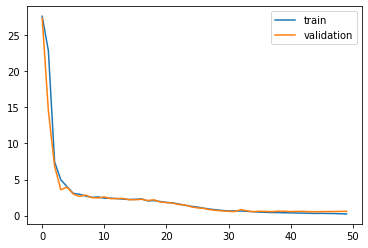

In [9]:
L = 12.8
sigma = 0.1
N = 32
epochs = 50

seed_everything()
device = get_default_device()

net = VoxelNet(nchannel)
net = net.to(device)

ml_train = MolLoader(train_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=64, nchannel=nchannel,
               shuffle=True, rotate_randomly=True, device=device, reduce_data=False)

ml_test = MolLoader(test_df, sigma=sigma, elements=elements,
                   L=L, N=N, batch_size=128, nchannel=nchannel,
                   shuffle=False, rotate_randomly=False, device=device, reduce_data=False)

fit(epochs, net, ml_train, ml_test, torch.optim.Adam, lr=0.001, weight_decay=0)

### Train Plots

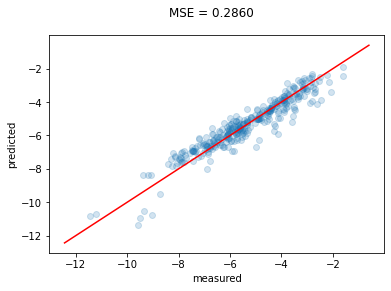

In [10]:
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False)
ys, y_hats = predict(net, ml_pred)
plot_predictions(ys, y_hats)

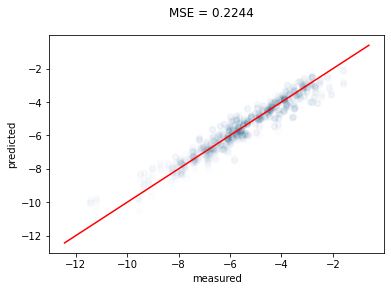

In [11]:
# rotations
seed_everything()
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
plot_predictions(ys, y_hats, alpha=0.01)

### Test Plots

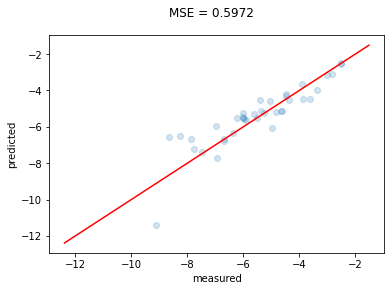

In [12]:
ml_pred = ml_test
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False)
ys, y_hats = predict(net, ml_pred)
plot_predictions(ys, y_hats)

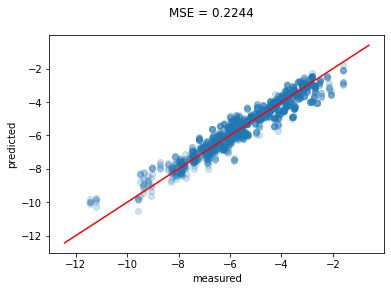

In [13]:
# rotations
seed_everything()
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
plot_predictions(ys, y_hats)

Initialised LazyMolLoader with 339 molecules. sigma=0.1, L=12.8, N=32, nchannel=76, shuffle=True, rotate=True, device=cuda
Initialised LazyMolLoader with 38 molecules. sigma=0.1, L=12.8, N=32, nchannel=76, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 27.649011611938477 val loss 27.423416137695312
Epoch 1: train loss 22.86301612854004 val loss 14.535316467285156
Epoch 2: train loss 7.457096099853516 val loss 6.862462997436523
Epoch 3: train loss 4.960904598236084 val loss 3.5831716060638428
Epoch 4: train loss 4.020195484161377 val loss 3.9473912715911865
Epoch 5: train loss 3.080455780029297 val loss 2.993619918823242
Epoch 6: train loss 2.961697578430176 val loss 2.655860424041748
Epoch 7: train loss 2.711576223373413 val loss 2.8405439853668213
Epoch 8: train loss 2.521676778793335 val loss 2.4884889125823975
Epoch 9: train loss 2.5905158519744873 val loss 2.435825824737549
Epoch 10: train loss 2.4018094539642334 val loss 2.590648889541626
Epoch 11: train loss 2.41493

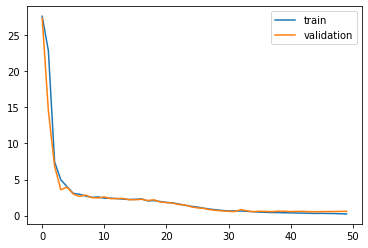

In [14]:
L = 12.8
sigma = 0.1
N = 32
epochs = 50

seed_everything()
device = get_default_device()

net = VoxelNet(nchannel)
net = net.to(device)

ml_train = LazyMolLoader(train_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=64, nchannel=nchannel,
               shuffle=True, rotate_randomly=True, device=device)

ml_test = LazyMolLoader(test_df, sigma=sigma, elements=elements,
                   L=L, N=N, batch_size=128, nchannel=nchannel,
                   shuffle=False, rotate_randomly=False, device=device)

fit(epochs, net, ml_train, ml_test, torch.optim.Adam, lr=0.001, weight_decay=0)

Initialised MolLoader with 339 molecules. sigma = 0.1, L=12.8, N=32, nchannel=76, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 38 molecules. sigma = 0.1, L=12.8, N=32, nchannel=76, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 27.649011611938477 val loss 27.423416137695312
Epoch 1: train loss 22.86301612854004 val loss 14.535316467285156
Epoch 2: train loss 7.457096099853516 val loss 6.862462997436523
Epoch 3: train loss 4.960904598236084 val loss 3.5831716060638428
Epoch 4: train loss 4.020195484161377 val loss 3.9473912715911865
Epoch 5: train loss 3.080455780029297 val loss 2.993619918823242
Epoch 6: train loss 2.961697578430176 val loss 2.655860424041748
Epoch 7: train loss 2.711576223373413 val loss 2.8405439853668213
Epoch 8: train loss 2.521676778793335 val loss 2.4884889125823975
Epoch 9: train loss 2.5905158519744873 val loss 2.435825824737549
Epoch 10: train loss 2.4018094539642334 val loss 2.590648889541626
Epoch 11: train loss 2.414932012

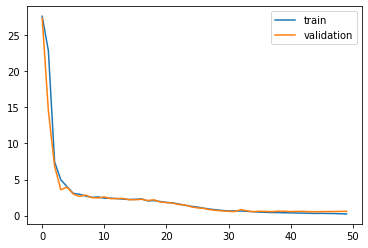

In [15]:
L = 12.8
sigma = 0.1
N = 32
epochs = 50

seed_everything()
device = get_default_device()

net = VoxelNet(nchannel)
net = net.to(device)

ml_train = MolLoader(train_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=64, nchannel=nchannel,
               shuffle=True, rotate_randomly=True, device=device, reduce_data=True)

ml_test = MolLoader(test_df, sigma=sigma, elements=elements,
                   L=L, N=N, batch_size=128, nchannel=nchannel,
                   shuffle=False, rotate_randomly=False, device=device, reduce_data=True)

fit(epochs, net, ml_train, ml_test, torch.optim.Adam, lr=0.001, weight_decay=0)